# Statistical analysis of supplied water at a municipal level

## (a) SIDRA API

**UN Environment**

In [1]:
import datetime; print(datetime.datetime.now())

2017-08-31 11:06:25.137088


The following document presents a multiple regression analysis of supplied water consumption at a municipal level for the country of Brazil.
We use available water consumption data at a municipal level to estimate the distribution of water consumption at a household level.
We make use of the SIDRA-API for the data collection. In order to get the data for all municipalities we download subsamples of data iteratively.

## Import local libraries.

The `parseData` script downloads and prepares municipal level data retrieved trough the SIDRA-API.

In [2]:
from API.sidra import getTable

/usr/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


We make use of standard python libraries for the statistical analysis and plotting of results.

In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
import matplotlib.pylab as plt
import seaborn as sns
sns.set(style="darkgrid", color_codes=True)

The `cap` parameter sets the value of the upper bound for the water supply variable.
The model under performs with large values and therefor we set the upper bound to 15000.

In [4]:
indicators=['water', 'income', 'urban', 'connection', 'ban', 'dutyp']
result = getTable(cap=15000, indicators=indicators, specific=False)

/home/esteban/Documents/UNEP/Data/Brasil-SIDRA-API/API/DATA/
DU typ	= 44795101	Households	Tab: 1442
HH size	= 3.62*
Income	= 44795101	Households	Tab: 3177
HH size	= 4.26*
Urban	= 44795101	Households	Tab: 761
Conn	= 44795101	Households	Tab: 1442
Toilets	= 44795101	Households	Tab: 1450
Water	= 56739726	m^3		Tab: 1773
* estimated values


In [5]:
print(result.head())

         Volume total de água com tratamento  Não tinham  1-5 banheiros  \
D4C                                                                       
1200054                                750.0       665.0          120.0   
1200104                               5000.0      3020.0         1049.0   
1200138                               1794.0      1114.0          241.0   
1200179                                900.0      1138.0          120.0   
1200203                               7800.0     10546.0         3395.0   

         Cômodo  Apartamento, Casa  Sem rendimento  Até 1 de salário mínimo  \
D4C                                                                           
1200054     9.0              776.0      674.519008               334.908782   
1200104    47.0             4022.0     2078.315024              1696.115241   
1200138    12.0             1343.0      842.111676               633.035674   
1200179     4.0             1254.0      857.598788               659.585007   


**Table 1: Data structure**

In addition to the upper bound set by `cap` we limit the sample to plausible per-capita values. We define these values between 1 and 500.

In [110]:
capita = result.iloc[:,-4:-2].sum(axis=1)
result.loc[:, 'watercp'] = result.iloc[:,0].div(capita).mul(1000)
result = result[(result.watercp <= 3000) & (result.watercp >= 1)]

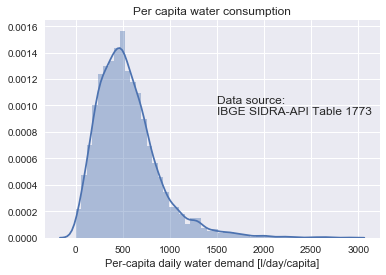

In [112]:
g = sns.distplot(result.loc[:,'watercp'])
g.set_xlabel(u'Per-capita daily water demand [l/day/capita]')
g.set_title('Per capita water consumption')
plt.text(1500, 0.001, "Data source:\nIBGE SIDRA-API Table 1773", ha='left', va='center');
plt.savefig("FIGURES/water_demand.png", dpi=300)

**Figure 1: Estimated per-capita water consumption at a municipal level**

We fit the statistical model with an `OLS` regression.

In [39]:
result.columns = [
    'Water',
    'Bathroom_no',
    'Bathroom_yes',
    'DwellingUnit_Room',
    'DwellingUnit_Unit',
    'Income_none',
    'Income_1',
    'Income_5',
    'Income_15',
    'Income_more',
    'WaterGrid_yes',
    'WaterGrid_no',
    'Urban_no',
    'Urban_yes',
    'watercp'
]

In [66]:
formula = "Water ~ \
Bathroom_yes + Bathroom_no+ \
DwellingUnit_Unit + \
WaterGrid_no + \
Urban_yes"

In [67]:
model = sm.OLS.from_formula(formula, result)
model_results = model.fit()
print(model_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Water   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     1430.
Date:                Wed, 30 Aug 2017   Prob (F-statistic):               0.00
Time:                        18:33:27   Log-Likelihood:                -36351.
No. Observations:                4110   AIC:                         7.271e+04
Df Residuals:                    4104   BIC:                         7.275e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           423.6252     40.56

The model is statistical significant.

In [38]:
result_est = result.loc[:, ['Water','Bathroom_yes','DwellingUnit_Unit','Income_none','Urban_yes']]
result_est['Estimated treated water'] = model_results.predict(result_est.iloc[:, 1:])#[0]

PatsyError: Error evaluating factor: NameError: name 'Bathroom_no' is not defined
    Water ~ Bathroom_yes + Bathroom_no + DwellingUnit_Unit + DwellingUnit_Room + Income_none + Income_1 + Income_5 + Income_15 + Income_more + WaterGrid_no + Urban_yes + Urban_no
                           ^^^^^^^^^^^

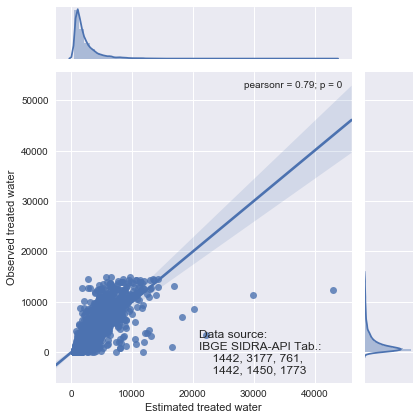

In [18]:
g = sns.jointplot(x='Estimated treated water',
                  y='Water',
                  data=result_est, kind='reg')
g.set_axis_labels('Estimated treated water', 'Observed treated water')
plt.text(21000, 0,
"""Data source:
IBGE SIDRA-API Tab.:
    1442, 3177, 761,
    1442, 1450, 1773""",
         ha='left', va='center');
plt.tight_layout()
plt.savefig('FIGURES/estimated_water.png', dpi=300)

**Figure 2: Performance of the model**

In [83]:
result.loc[:, 'Income_more15'] = result.loc[:, 'Income_15'] + result.loc[:, 'Income_more']

In [102]:
formula = "Water ~ \
Bathroom_yes + \
DwellingUnit_Unit + \
Income_more15 + \
WaterGrid_yes + \
Urban_yes"

result_cap = result.div(capita, axis=0).mul(1000)
result_cap = result_cap.dropna()

model_cap = sm.OLS.from_formula(formula, result_cap)
model_results_cap = model_cap.fit()
print(model_results_cap.summary())

                            OLS Regression Results                            
Dep. Variable:                  Water   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                     376.7
Date:                Wed, 30 Aug 2017   Prob (F-statistic):               0.00
Time:                        18:41:32   Log-Likelihood:                -29093.
No. Observations:                4110   AIC:                         5.820e+04
Df Residuals:                    4104   BIC:                         5.824e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           692.5693    501.77

In [104]:
result_est_cap = result_cap.loc[:, [
    'Water','Bathroom_yes','DwellingUnit_Unit','Income_more15','Urban_yes','WaterGrid_yes']]
result_est_cap['Estimated treated water'] = model_results_cap.predict(result_est_cap.iloc[:, 1:])#[0]

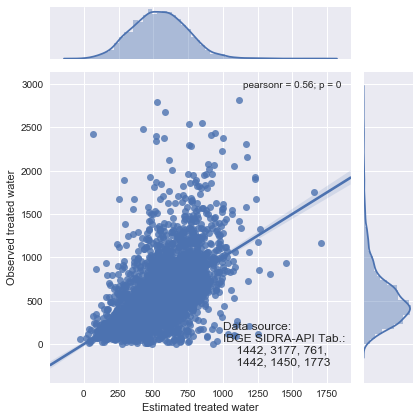

In [105]:
g = sns.jointplot(x='Estimated treated water',
                  y='Water',
                  data=result_est_cap, kind='reg')
g.set_axis_labels('Estimated treated water', 'Observed treated water')
plt.text(1000, 0,
"""Data source:
IBGE SIDRA-API Tab.:
    1442, 3177, 761,
    1442, 1450, 1773""",
         ha='left', va='center');
plt.tight_layout()
plt.savefig('FIGURES/estimated_water_cap.png', dpi=300)